In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm


from networks import DeepSurv, NegativeLogLikelihood
from utils import c_index
import torch

In [2]:
device = 'cuda:0'

In [3]:
config = {'train': {
  'learning_rate': 0.0001,
  'lr_decay_rate': 0.2,
  'optimizer': 'Adam'},
 'network': {'drop': 0.3,
  'norm': True,
  'dims': [9,100,100, 1],
  'activation': 'ReLU',
  'l2_reg': 0.3}}

model = DeepSurv(config['network'], device)
#print(model)

loss_function = NegativeLogLikelihood(config['network']).to(device)
#print(loss_function)


In [4]:
optimizer = eval('torch.optim.{}'.format(config['train']['optimizer']))(
        model.parameters(), lr=config['train']['learning_rate'])

In [7]:

from sksurv.datasets import load_gbsg2
data_x, data_y = load_gbsg2()
life = pd.concat([data_x, pd.DataFrame(data_y)], axis = 1)
from sksurv.preprocessing import OneHotEncoder

life = OneHotEncoder().fit_transform(life)

life


age  estrec  horTh=yes  menostat=Post  pnodes  progrec  tgrade=II  \
0    70.0    66.0        0.0            1.0     3.0     48.0        1.0   
1    56.0    77.0        1.0            1.0     7.0     61.0        1.0   
2    58.0   271.0        1.0            1.0     9.0     52.0        1.0   
3    59.0    29.0        1.0            1.0     4.0     60.0        1.0   
4    73.0    65.0        0.0            1.0     1.0     26.0        1.0   
..    ...     ...        ...            ...     ...      ...        ...   
681  49.0    84.0        0.0            0.0     3.0      1.0        0.0   
682  53.0     0.0        1.0            1.0    17.0      0.0        0.0   
683  51.0     0.0        0.0            0.0     5.0     43.0        0.0   
684  52.0    34.0        0.0            1.0     3.0     15.0        1.0   
685  55.0    15.0        0.0            1.0     9.0    116.0        1.0   

     tgrade=III  tsize   cens    time  
0           0.0   21.0   True  1814.0  
1           0.0   12.0   True  2018.0  
2           0.0   35.0   True   712.0  
3           0.0   17.0   True  1807.0  
4           0.0   35.0   True   772.0  
..          ...    ...    ...     ...  
681         1.0   30.0  False   721.0  
682         1.0   25.0  False   186.0  
683         1.0   25.0   True   769.0  
684         0.0   23.0   True   727.0  
685         0.0   23.0   True  1701.0  

[686 rows x 11 columns]

In [8]:
class SurvivalDataset(torch.utils.data.Dataset):
    
    def __init__(self, covx, event, time):
        '''
        note that inputs are normalized numpy
        '''
        self.covx = covx
        self.event = event
        self.time = time
        print(covx.shape, event.shape, time.shape)
    
    def __getitem__(self, index):
        # gets data with index of item
        X_item = self.covx[index] # (m)
        e_item = self.event[index] # (1)
        y_item = self.time[index] # (1)

        # constructs torch.Tensor object
        X_tensor = torch.from_numpy(X_item).to(torch.float32)
        e_tensor = torch.from_numpy(e_item).to(torch.float32)
        y_tensor = torch.from_numpy(y_item).to(torch.float32)
        return X_tensor, y_tensor, e_tensor

    def __len__(self):
        return self.covx.shape[0]

In [9]:
cols = list(life.columns)

cols.remove('cens')
cols.remove('time')
covx = life

import pandas as pd
from sklearn import preprocessing

x = covx.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
covx, event, time = df[list(range(9))].to_numpy(), df[[9]].to_numpy(), df[[10]].to_numpy()

In [10]:
ratio = 0.9
train_valid_dataset = SurvivalDataset(covx[:500, :], event[:500], time[:500])

train_len = int(len(train_valid_dataset)*ratio)
valid_len = len(train_valid_dataset) - train_len

train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [train_len, valid_len])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_dataset.__len__())
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=valid_dataset.__len__())



test_dataset = SurvivalDataset(covx[500:, :], event[500:], time[500:])
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_dataset.__len__())

print(train_dataset.__len__(), valid_dataset.__len__(), test_dataset.__len__())

(500, 9) (500, 1) (500, 1)
(186, 9) (186, 1) (186, 1)
450 50 186


In [11]:
class Trainer():
    def initialize(self, train_loader, valid_loader, test_loader, optimizer, model, loss_function, c_index_function, device, freq = 100):
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.model = model.to(device)
        self.loss_function = loss_function.to(device)
        self.c_index_function = c_index_function
        self.device = device
        self.freq = freq
    
    def one_epoch_train(self, epoch):
        self.model.train()
        loss_total = list()
        c_index_total = list()
        for x, y, e in self.train_loader:
            x = x.to(self.device)
            y = y.to(self.device)
            e = e.to(self.device)
            risk_pred = self.model(x)
            train_loss = self.loss_function(risk_pred, y, e, self.model, self.device)
            train_c = self.c_index_function(-risk_pred, y, e)

            self.optimizer.zero_grad()
            train_loss.backward()
            self.optimizer.step()

            loss_total.append(train_loss.cpu().detach().item())
            c_index_total.append(train_c)

        return np.array(loss_total).mean(), np.array(c_index_total).mean()
    
    def one_epoch_valid(self, epoch):
        self.model.eval()
        loss_total = list()
        c_index_total = list()
        with torch.no_grad():
            for x, y, e in self.valid_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                e = e.to(self.device)

                risk_pred = self.model(x).to(self.device)
                valid_loss = self.loss_function(risk_pred, y, e, self.model, self.device)
                valid_c = self.c_index_function(-risk_pred, y, e)

                loss_total.append(valid_loss.cpu().detach().item())
                c_index_total.append(valid_c)


            return np.array(loss_total).mean(), np.array(c_index_total).mean()

    def test(self):
        self.model.eval()
        with torch.no_grad():
            for x, y, e in self.test_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                e = e.to(self.device)

                risk_pred = self.model(x).to(self.device)
                test_loss = self.loss_function(risk_pred, y, e, self.model, self.device)
                test_c = self.c_index_function(-risk_pred, y, e)


                print(f'Test || loss : {round(test_loss.cpu().detach().item(), 3)} / c-index : {round(test_c, 3)}')

In [12]:
trainer = Trainer()
trainer.initialize(
    train_loader,
    valid_loader, 
    test_loader,
    optimizer,
    model,
    loss_function,
    c_index_function = c_index,
    device = 'cuda:0'
)

In [13]:
epochs = 3000
train_result = list()
valid_result = list()
for epoch in tqdm(range(epochs)):
    train_result.append(trainer.one_epoch_train(epoch))
    valid_result.append(trainer.one_epoch_valid(epoch))
trainer.test()

train_result = np.stack(train_result)
valid_result = np.stack(valid_result)

  0%|          | 0/3000 [00:00<?, ?it/s]

Test || loss : 4.633 / c-index : 0.644


In [ ]:
train_result.shape

(3000, 2)

Test || loss : 4.633 / c-index : 0.644


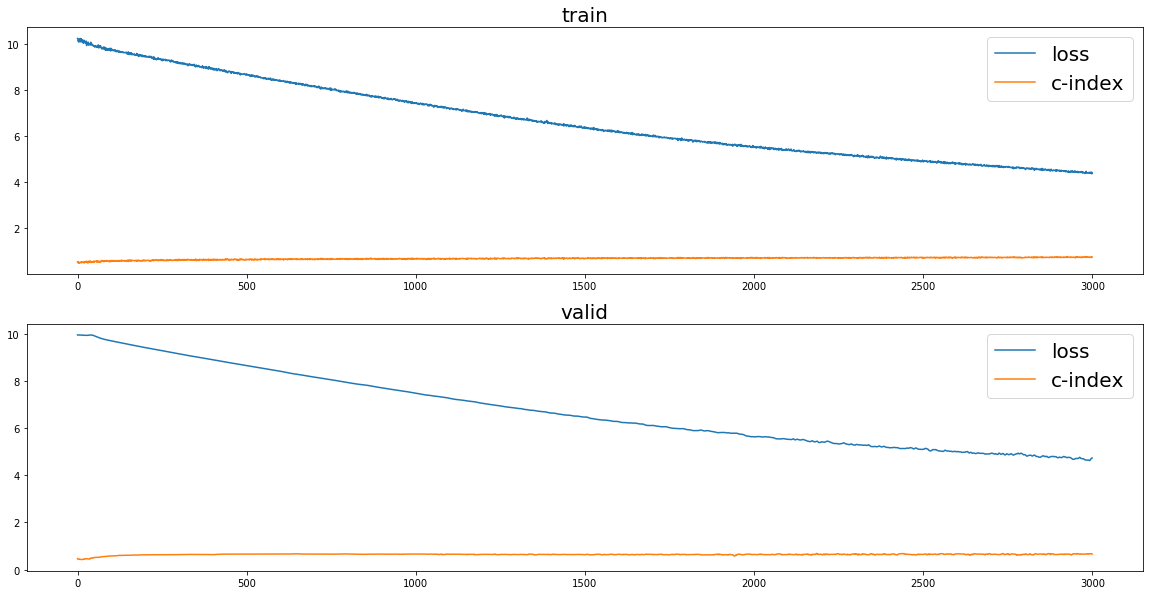

In [14]:
plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.plot(train_result[:, 0], label = 'loss')
plt.plot(train_result[:, 1], label = 'c-index')
plt.title('train', fontsize = 20)
plt.legend(fontsize = 20)

plt.subplot(2, 1, 2)
plt.plot(valid_result[:, 0], label = 'loss')
plt.plot(valid_result[:, 1], label = 'c-index')
plt.title('valid', fontsize = 20)
plt.legend(fontsize = 20)


trainer.test()

In [15]:
import torch.nn as nn
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        x = torch.tensor(x.to_numpy(), dtype=torch.float32).to(device)
        x = self.model(x)
        return x.detach().cpu().numpy()

    # Add the predict method
    def predict(self, x):
        return self.forward(x)

wrapped_model = WrappedModel(model)

In [16]:
feature_names = [f'feature_{i}' for i in range(1, 10)]
surv_XDF = pd.DataFrame(df[list(range(9))].to_numpy(), columns=feature_names)

In [ ]:
surv_XDF

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


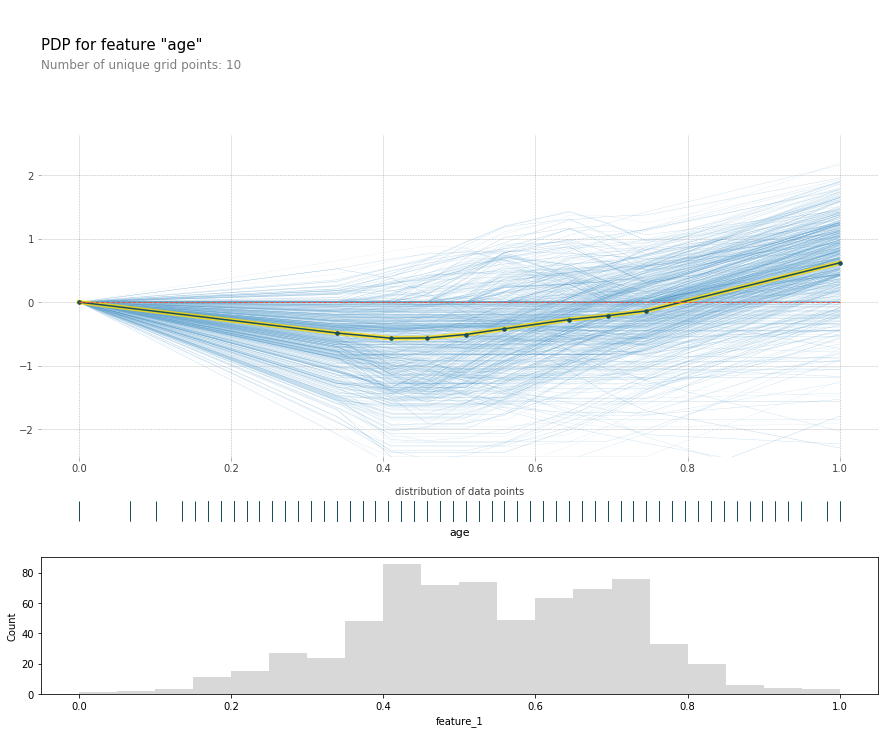

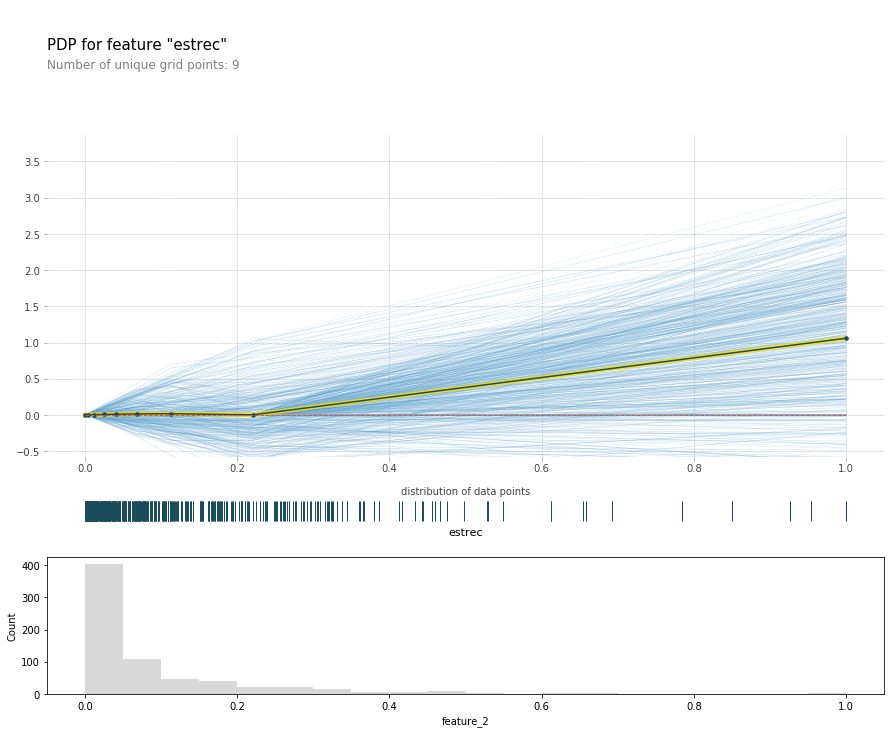

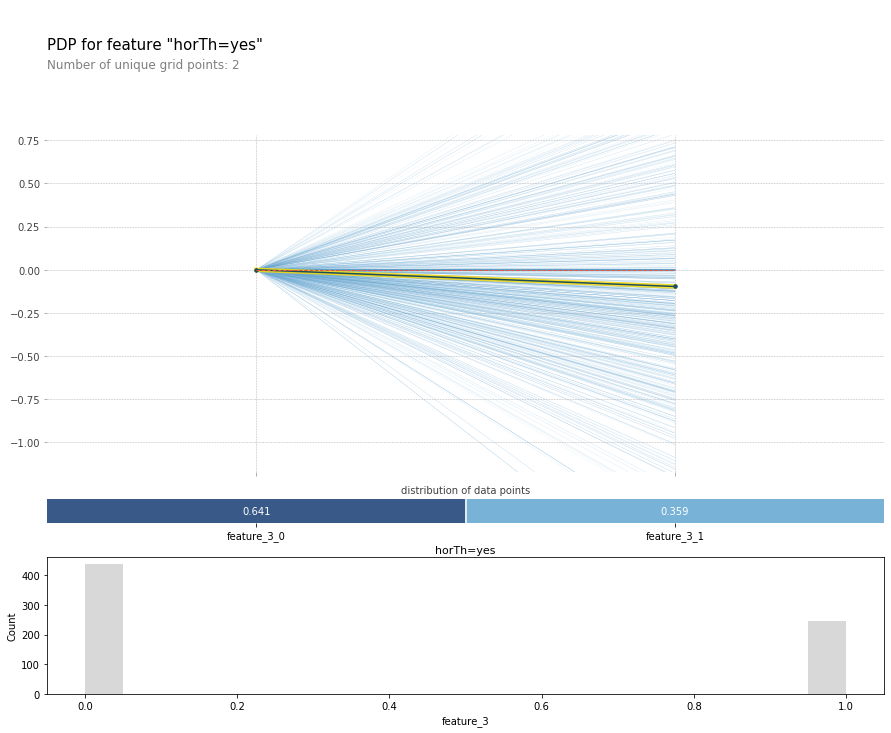

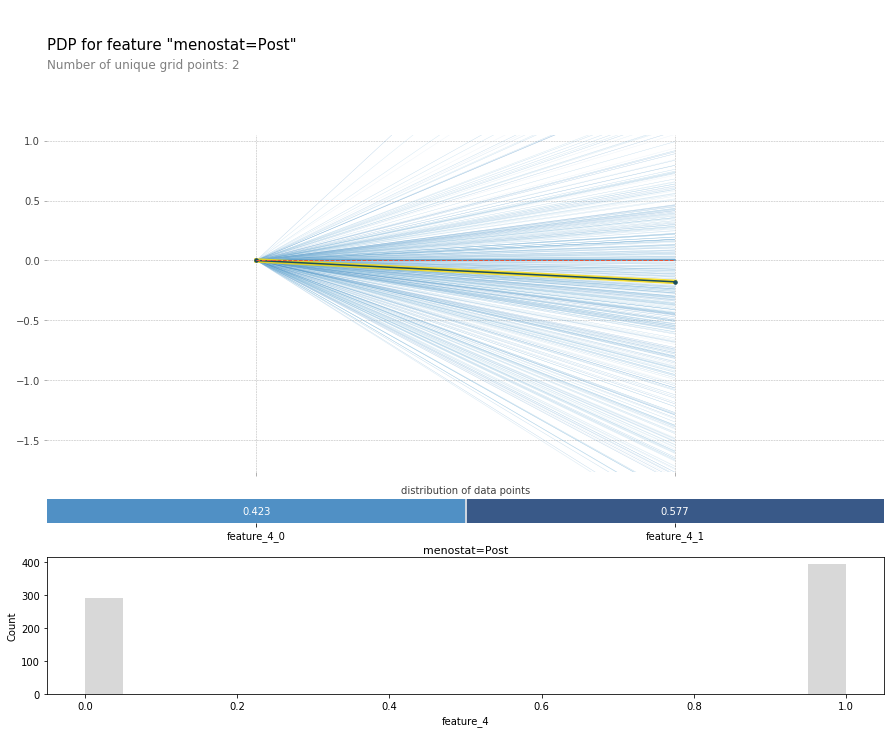

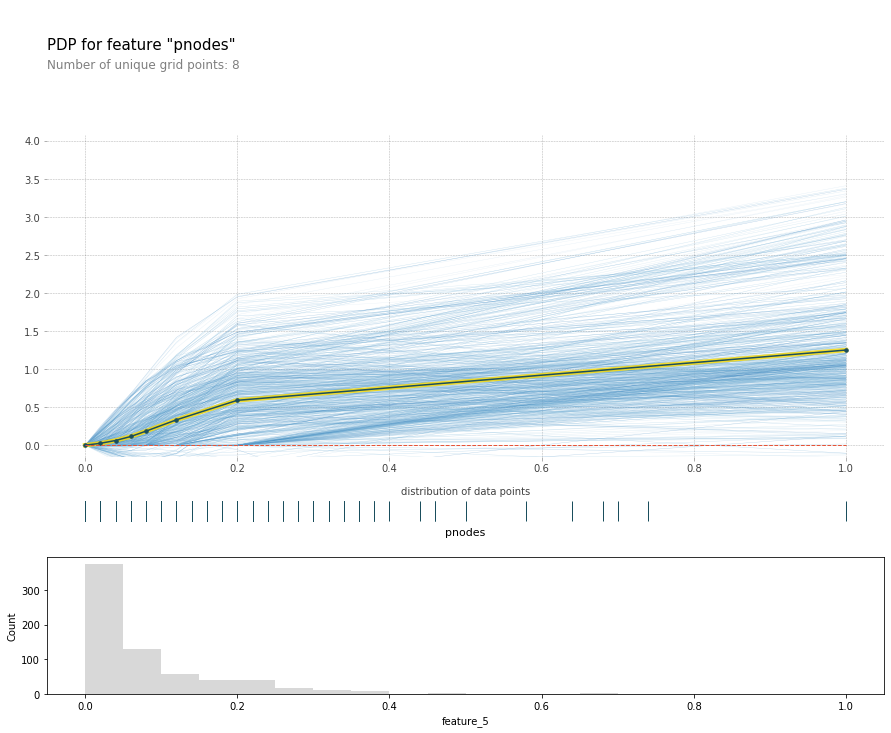

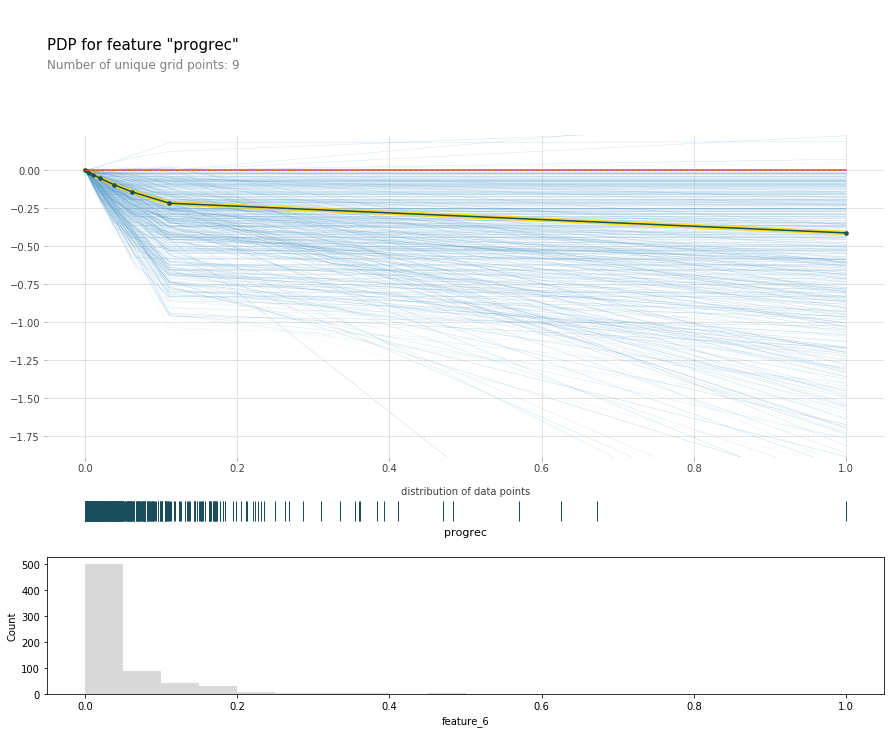

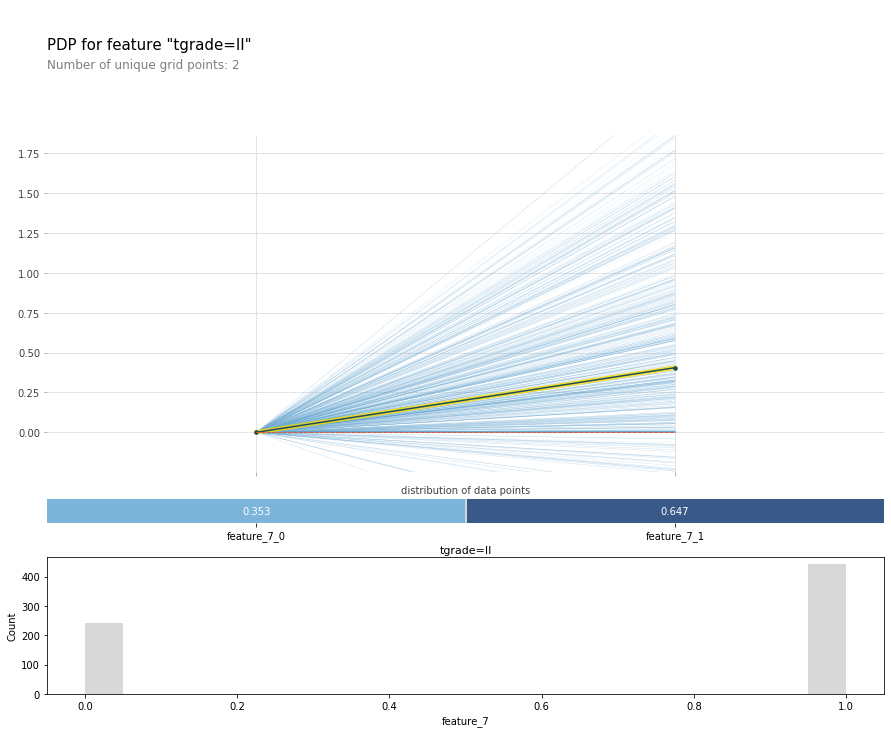

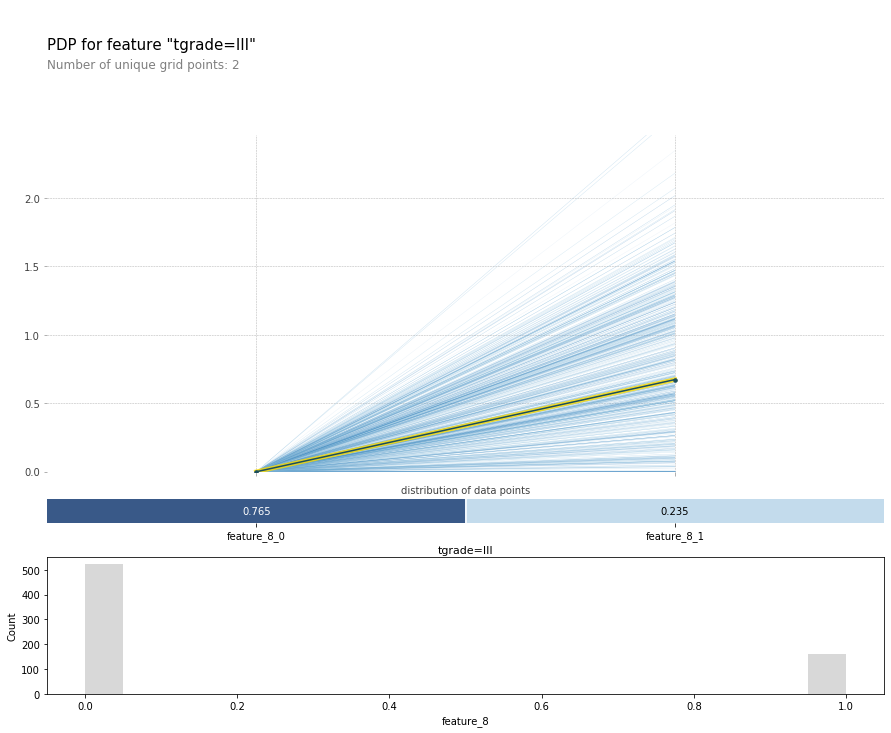

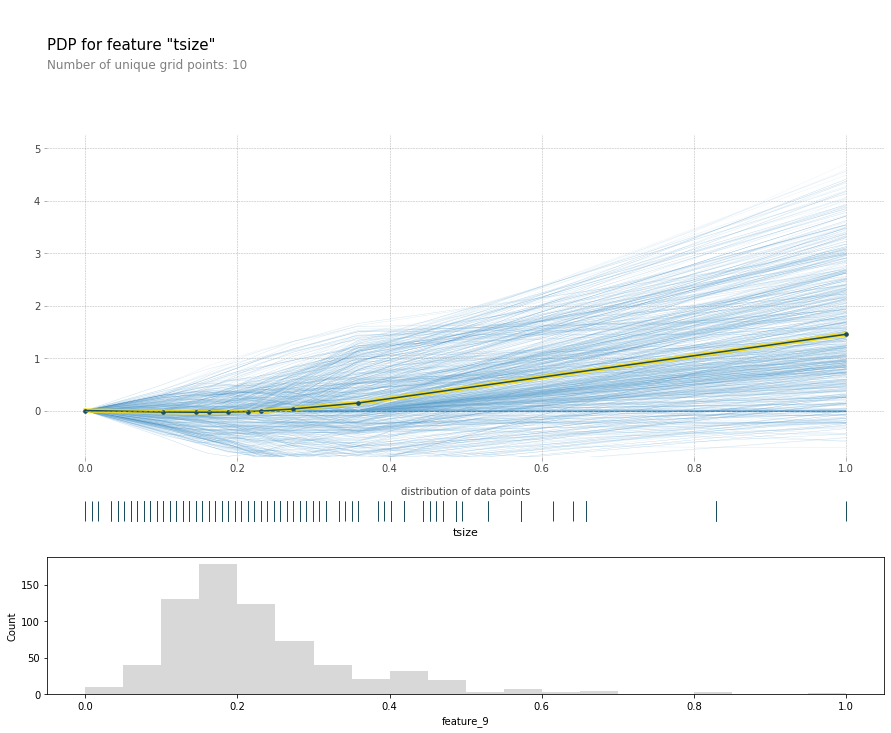

In [17]:
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot

# Generate the PDP plots with histograms below for all features
for i, feature in enumerate(feature_names, 1):
    pdp_feature = pdp_isolate(
        model=wrapped_model,
        dataset=surv_XDF,
        model_features=feature_names,
        feature=feature
    )
    fig, axes = pdp_plot(pdp_feature, cols[i-1], plot_lines=True, frac_to_plot=1, plot_pts_dist=True)

    # Add a histogram of the feature values below the PDP plot
    ax2 = fig.add_axes([fig.axes[-1].get_position().x0, fig.axes[-1].get_position().y0 - 0.25,
                        fig.axes[-1].get_position().width, 0.2])
    ax2.hist(surv_XDF[feature], bins=20, alpha=0.3, color='gray')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('Count')

    plt.show()


In [18]:
surv_XDF

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0     0.830508   0.057692        0.0        1.0       0.04   0.020168   
1     0.593220   0.067308        1.0        1.0       0.12   0.025630   
2     0.627119   0.236888        1.0        1.0       0.16   0.021849   
3     0.644068   0.025350        1.0        1.0       0.06   0.025210   
4     0.881356   0.056818        0.0        1.0       0.00   0.010924   
..         ...        ...        ...        ...        ...        ...   
681   0.474576   0.073427        0.0        0.0       0.04   0.000420   
682   0.542373   0.000000        1.0        1.0       0.32   0.000000   
683   0.508475   0.000000        0.0        0.0       0.08   0.018067   
684   0.525424   0.029720        0.0        1.0       0.04   0.006303   
685   0.576271   0.013112        0.0        1.0       0.16   0.048739   

     feature_7  feature_8  feature_9  
0          1.0        0.0   0.153846  
1          1.0        0.0   0.076923  
2          1.0        0.0   0.273504  
3          1.0        0.0   0.119658  
4          1.0        0.0   0.273504  
..         ...        ...        ...  
681        0.0        1.0   0.230769  
682        0.0        1.0   0.188034  
683        0.0        1.0   0.188034  
684        1.0        0.0   0.170940  
685        1.0        0.0   0.170940  

[686 rows x 9 columns]

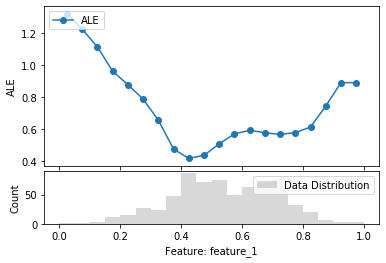

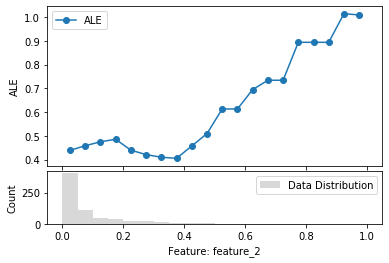

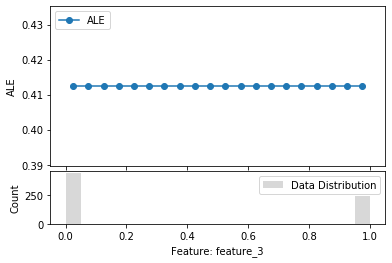

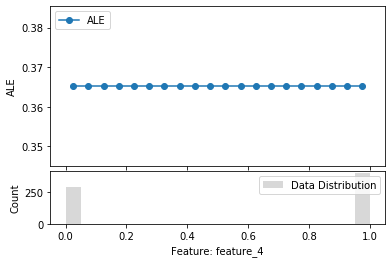

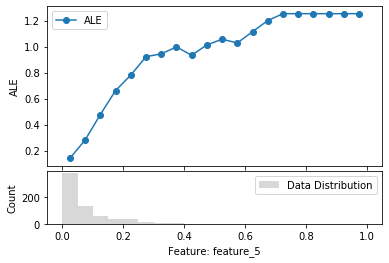

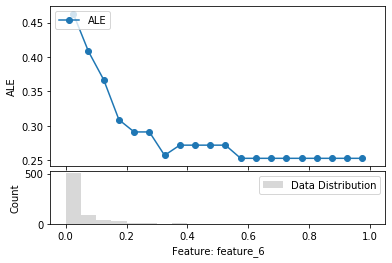

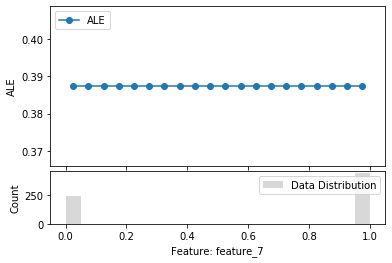

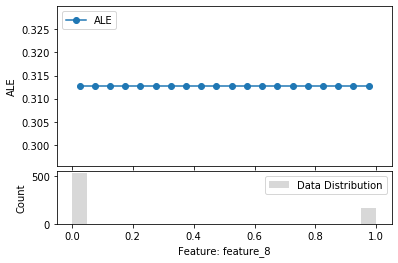

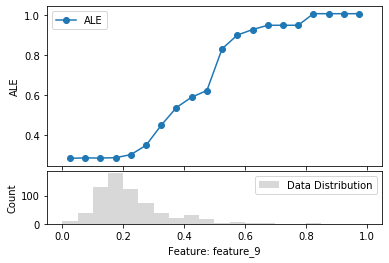

In [19]:
from PyALE import ale

import torch.nn as nn
from sklearn.base import BaseEstimator

# ... (all previous code up to WrappedModel definition remains the same)

import torch.nn as nn
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        x = torch.tensor(x.to_numpy(), dtype=torch.float32).to(device)
        x = self.model(x)
        return x.detach().cpu().numpy()

    # Add the predict method
    def predict(self, x):
        return self.forward(x)

wrapped_model = WrappedModel(model)
def model_predict(X):
    return wrapped_model.predict(X)

X_df = surv_XDF
def compute_ale(predict_fn, X, feature, bins=20):
    X_sorted = X.sort_values(by=feature)
    bin_edges = np.linspace(X_sorted[feature].min(), X_sorted[feature].max(), bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ale_values = np.zeros(bins)

    for i in range(bins):
        subset = X_sorted[(X_sorted[feature] >= bin_edges[i]) & (X_sorted[feature] < bin_edges[i + 1])]
        if len(subset) == 0:
            continue
        ale_values[i] = predict_fn(subset).mean()
        if i > 0:
            modified_subset = subset.copy()
            modified_subset[feature] = bin_centers[i - 1]
            ale_values[i] -= predict_fn(modified_subset).mean()
    
    return bin_centers, np.cumsum(ale_values)


def plot_ale_with_bottom_histogram(predict_fn, X, feature, bins=20):
    bin_centers, ale_values = compute_ale(predict_fn, X, feature, bins)
    
    # Create the ALE plot and histogram in a 2-row grid
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.subplots_adjust(hspace=0.05)

    # ALE plot
    ax1.plot(bin_centers, ale_values, marker='o', label='ALE')
    ax1.set_ylabel(f'ALE')
    ax1.legend(loc='upper left')

    # Histogram (data distribution)
    ax2.hist(X[feature], bins=bins, alpha=0.3, color='gray', label='Data Distribution')
    ax2.set_xlabel(f'Feature: {feature}')
    ax2.set_ylabel('Count')
    ax2.legend(loc='upper right')

    plt.show()

# Generate the ALE plots with histograms below for all features
for i, feature in enumerate(feature_names, 1):
    plot_ale_with_bottom_histogram(wrapped_model.predict, X_df, feature, bins=20)



# ICE

In [20]:
from pycebox.ice import ice, ice_plot
import torch.nn as nn
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = self.model(x)
        return x.detach().cpu().numpy()

    # Add the predict method
    def predict(self, x):
        return self.forward(x)

wrapped_model = WrappedModel(model)


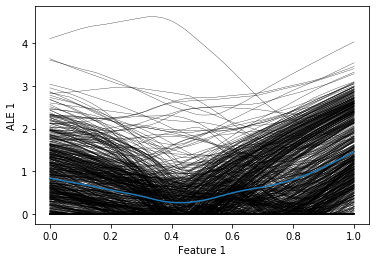

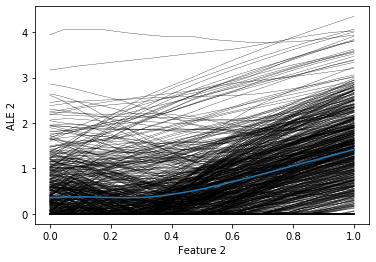

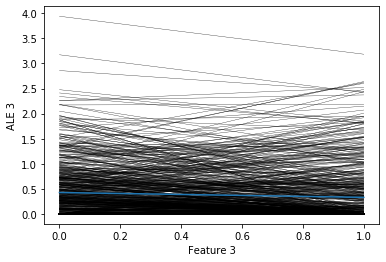

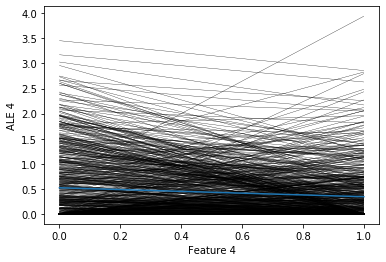

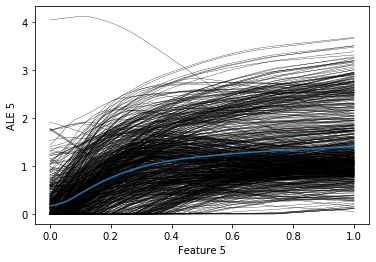

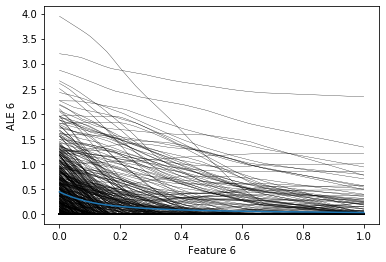

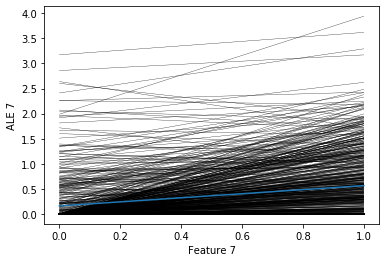

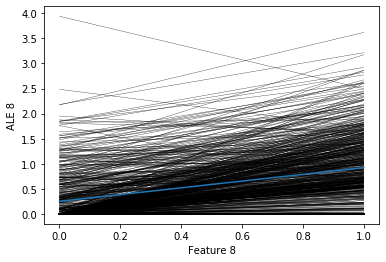

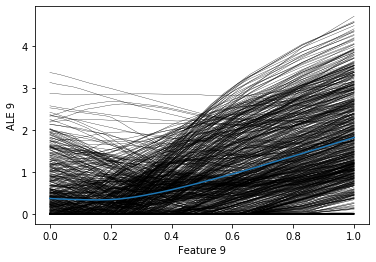

In [21]:
for i, feature in enumerate(feature_names, 1):
    centered_ice_df = ice(data=surv_XDF, column=feature, predict=wrapped_model.predict)
    ice_plot(centered_ice_df, c='k', linewidth=0.3, plot_pdp=True)
    plt.xlabel(f'Feature {i}')
    plt.ylabel(f'ALE {i}')
    plt.show()

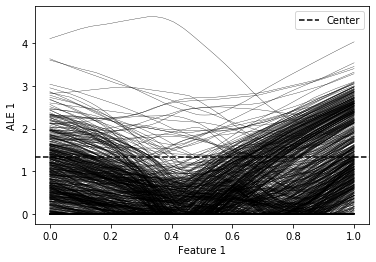

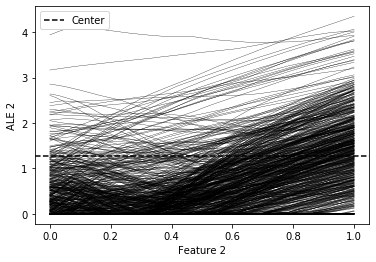

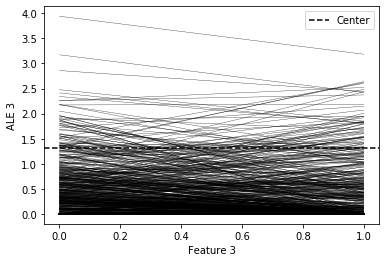

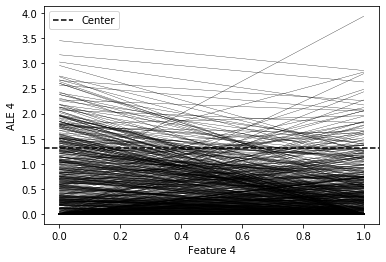

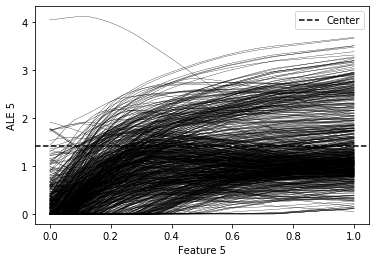

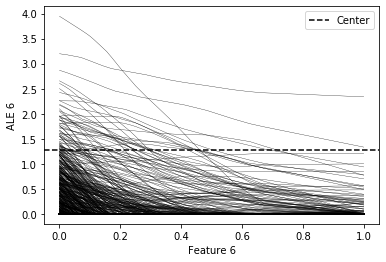

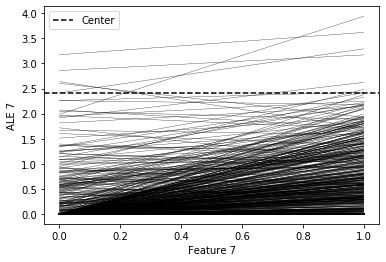

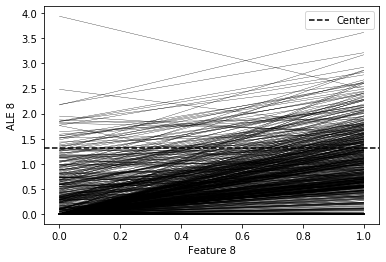

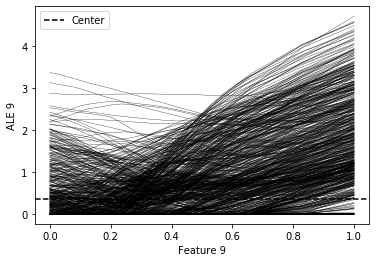

In [22]:
for i, feature in enumerate(feature_names, 1):
    centered_ice_df = ice(data=surv_XDF, column=feature, predict=wrapped_model.predict)
    fig, ax = plt.subplots()
    ax.axhline(y=centered_ice_df.iloc[0].values[0], color='k', linestyle='--', label='Center')
    ice_plot(centered_ice_df, ax=ax, c='k', linewidth=0.3)
    plt.xlabel(f'Feature {i}')
    plt.ylabel(f'ALE {i}')
    plt.legend()
    plt.show()


In [ ]:
def prototype_and_criticisms(model, X_train, y_train, X_test, y_test, k_prototypes=5, k_criticisms=5, device='cpu'):
    """
    Identifies prototype and criticism examples for a given PyTorch survival model.

    Parameters:
        model (nn.Module): A trained PyTorch model.
        X_train (numpy array or tensor): The training data (samples x features).
        y_train (numpy array or tensor): The training target (survival data).
        X_test (numpy array or tensor): The testing data (samples x features).
        y_test (numpy array or tensor): The testing target (survival data).
        k_prototypes (int): Number of prototype examples to identify.
        k_criticisms (int): Number of criticism examples to identify.
        device (str): Device to use for computation ('cpu' or 'cuda').

    Returns:
        A tuple of (prototypes, criticisms), where each is a tuple of the form (X, y).
    """
    # Set model to evaluation mode
    model.eval()

    # Convert inputs to tensors and move to device
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Compute training and testing predictions
    train_pred = model(X_train).squeeze().detach().cpu().numpy()
    test_pred = model(X_test).squeeze().detach().cpu().numpy()

    # Compute residuals for training and testing data
    train_resid = y_train[:, 0].cpu().numpy() - train_pred
    test_resid = y_test[:, 0].cpu().numpy() - test_pred

    # Identify prototype examples
    prototypes = np.zeros((k_prototypes, X_train.shape[1]))
    for i in range(k_prototypes):
        # Find index of example with highest absolute residual
        idx = np.argmax(np.abs(train_resid))
        # Add example to prototypes
        prototypes[i, :] = X_train[idx, :].cpu().numpy()
        # Remove example from training data and residuals
        X_train = torch.cat([X_train[:idx, :], X_train[(idx+1):, :]], dim=0)
        y_train = torch.cat([y_train[:idx, :], y_train[(idx+1):, :]], dim=0)
        train_resid = np.concatenate([train_resid[:idx], train_resid[(idx+1):]], axis=0)

    # Identify criticism examples
    criticisms = np.zeros((k_criticisms, X_test.shape[1]))
    for i in range(k_criticisms):
        # Find index of example with highest absolute residual
        idx = np.argmax(np.abs(test_resid))
        # Add example to criticisms
        criticisms[i, :] = X_test[idx, :].cpu().numpy()
        # Remove example from testing data and residuals
        X_test = torch.cat([X_test[:idx, :], X_test[(idx+1):, :]], dim=0)
        y_test = torch.cat([y_test[:idx, :], y_test[(idx+1):, :]], dim=0)
        test_resid = np.concatenate([test_resid[:idx], test_resid[(idx+1):]], axis=0)

    return (prototypes, criticisms)


In [ ]:
prototypes, criticisms = prototype_and_criticisms(model = model.cpu(), 
X_train = surv_XDF.to_numpy()[:100], 
y_train = (life[['Status', 'Survival_in_days']].to_numpy()[:100]*1).astype('float64'), 
X_test = surv_XDF.to_numpy()[100:],
y_test = (life[['Status', 'Survival_in_days']].to_numpy()[100:]*1).astype('float64'), 
k_prototypes=5, 
k_criticisms=5, 
device='cpu')

In [ ]:
k_prototypes = 5
k_criticisms = 5
fig, axs = plt.subplots(nrows=2, ncols=k_prototypes, figsize=(20, 6))
for i in range(k_prototypes):
    axs[0, i].plot(prototypes[i])
    axs[0, i].set_title(f"Prototype {i+1}")
for i in range(k_criticisms):
    axs[1, i].plot(criticisms[i])
    axs[1, i].set_title(f"Criticism {i+1}")
plt.tight_layout()
plt.show()